<a href="https://colab.research.google.com/github/yaobviously/sym-cargo/blob/main/sym_cargo_alt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install plotly-express --quiet
!pip install vincenty --quiet
!pip install --upgrade catboost --quiet

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from catboost import CatBoostClassifier, Pool
from keras.models import Sequential
from keras.layers import Embedding, RepeatVector, LSTM, Dense, TimeDistributed
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from xgboost import XGBClassifier
from vincenty import vincenty
import plotly_express as px

In [5]:
port_file = '/content/drive/MyDrive/Ports/ports.csv'
tracking_file = '/content/drive/MyDrive/Ports/tracking.csv'

In [6]:
def wrangle():
  
  df1 = pd.read_csv(port_file)

  # converting lat and long to radians to compute haversine distance
  df1['lat_rad'] = np.radians(df1['lat'])
  df1['long_rad'] = np.radians(df1['long'])
  
  # rounding lat and long in port df
  df1['lat'] = df1['lat']
  df1['long'] = df1['long']
  df1['lat_long'] = [[x,y] for x, y in zip(df1['lat'], df1['long'])]

  df2 = pd.read_csv(tracking_file, parse_dates=['datetime'])
  df2 = df2.drop_duplicates()
  df2 = df2.sort_values(['vessel', 'datetime'])
  df2['vessel_1back'] = df2['vessel'].shift()
  
  # converting lat and long to radians to compute haversine distance  
  df2['lat_rad'] = np.radians(df2['lat'])
  df2['long_rad'] = np.radians(df2['long'])

  # adding lat/long column and lat/long 1 back to later compute delta
  df2['lat_long'] = [[x,y] for x, y in zip(df2['lat'], df2['long'])]
  df2['lat_long_1back'] = df2.groupby('vessel')['lat_long'].transform(lambda x: x.shift())
  df2['direction'] = pd.cut(df2['heading'],
                            bins=[0, 22.5, 67.5, 112.5, 157.5, 202.5, 247.5,
                                  292.5, 337.5, 360],
                            labels=['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'],
                            ordered=False,
                            include_lowest=True)
  
  # time delta and hour delta that will be used for filtering - i do it again
  # after the filter

  df2['time_delta'] = df2.groupby('vessel')['datetime'].transform(lambda x: x - x.shift())
  df2['hour_delta'] = [n.total_seconds()/3600 for n in df2['time_delta']]

  # i divide the map into quadrants to calculate the proportion of the time each
  # vessel was in each quadrant

  conditions = [((df2['lat'] > 0) & (df2['long'] > 0)),
                ((df2['lat'] < 0) & (df2['long'] > 0)), 
                ((df2['lat'] > 0) & (df2['long'] < 0)), 
                ((df2['lat'] < 0) & (df2['long'] < 0))
  ]

  labels = ['quad1', 'quad4', 'quad2', 'quad3']

  df2['quad'] = np.select(conditions, labels)
  

  # filtering using query to eliminate unneeded/impossible values
  df2 = df2.query('speed <30 & heading <=360 & draft < 13.5')
  df2 = df2.reset_index(drop=True)

  return df1, df2

In [7]:
df1, df2 = wrangle()

In [8]:
def vincent_distance(row):
  """ 
  returns the vincenty distance for contiguous rows - will be used to identify
  impossible distances travelled, and so on. could be used to create distance
  matrix, but this may not be worthwhile 
  """
  if row['vessel'] != row['vessel_1back']:
    return -99

  loc1 = row['lat_long']
  loc2 = row['lat_long_1back']

  try:
    distance = vincenty(loc1, loc2)
    return distance
  except:
    return -99

In [9]:
# creating a dictionary of ports with their lat and longs - will be used
# repeatedly to explore data and assign values

ports = {port:(lat, long) for port, lat, long in zip(df1['port'], df1['lat'], df1['long'])}

# a dictionary to retrieve the port id from the index
idx_ports = {idx:port for idx, port in zip(df1.index, df1.port)}

In [10]:
# getting the vincenty distances for each pair of ports in the ports.csv file
# extracting those that are within 100km of each other

close_ones = []

for x in df1['lat_long']:
  distances = []
  for y in df1['lat_long']:
    vdist = vincenty(x, y)
    distances.append(vdist)
  close_ones.append(distances)

disters = [[(df1['port'].iloc[n], z) for n, z in zip(np.argsort(p)[:5], sorted(p)[:5])] for p in close_ones]

close_ones = {}

for n in disters:
  port = n[0][0]
  dees = {d:v for d, v in n[1:] if v < 100}
  close_ones[port] = dees

close_ones = {k:v for k,v in close_ones.items() if len(v) >= 1}

really_close = [30, 109, 42, 51, 65, 71, 108, 139, 63, 152, 102]

In [12]:
# training a nearest neighbor model to  find the closest port when the 
# conditions indicating an extended stop have occurred. the metric is haversine
# in order to compute the 'great circle' distance. so i don't forget, the model
# returns the *index* of the port, not the port's identifying label

ports_train = df1[['lat_rad', 'long_rad']]

neigh_ports = NearestNeighbors(n_neighbors=3, algorithm='ball_tree', metric='haversine')
neigh_ports.fit(ports_train)

dist, n = neigh_ports.kneighbors(np.array([0.677565, 0.469731]).reshape(1,-1))

print(dist[0] * 6370)
print([idx_ports[n] for n in n[0]])

[  3.30931026  46.44757565 255.13837716]
[82, 113, 44]


In [13]:
def nearest_port(df, radius=0.015):
  """
  returns the port identifier of the nearest port using the nearest neighbors
  model 
  """

  data = np.array([df['lat_rad'], df['long_rad']]).reshape(1, -1)
  dist, pred = neigh_ports.radius_neighbors(data, radius=radius, sort_results = True) 

  if len(dist[0]) == 0:
    return -1
  
  else:
    return idx_ports[pred[0][0]]

In [14]:
def nearest_distance(df, radius=0.015):
  """
  returns the distance of the nearest port in the dataset
  """
  
  data = np.array([df['lat_rad'], df['long_rad']]).reshape(1, -1)
  dist, pred = neigh_ports.radius_neighbors(data, radius=radius, sort_results = True) 

  if len(dist[0]) == 0:
    return -1
  
  else:
    return dist[0][0]

In [15]:
def vincenty_port(row):
  """
  a function that computes the vincenty distance between the assigned port
  and the latitude and longitude of the location data
  """
  port = row['port_coords']
  loc = row['lat_long']
  return vincenty(port, loc)

In [16]:
def train_dbscan(df=df1, eps=0.1, min_samples=4):
  """
  use the dbscan clustering algorithm to find groupss of ports

  params
  ------
      df: pandas df
      eps: min distance between points in cluster
      min_samples: min members in a cluster

  returns
  -------
      labels: labels matching index of long/lat input pairs
  """
  
  coords = df[['long_rad', 'lat_rad']].values
  db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine')

  db.fit(coords)

  return db.labels_

In [17]:
def fix_ports(testdf):
  """
  fills out port sequences if there's a draft change in the sequence. this will
  help get better arrival and departure dates. it should be applied to 
  groupby DataFrames 

  parameters
  ----------
      df: a pandas DataFrame

  returns
  -------
      df: a pandas Series
  """
  
  ugh = []

  for x in testdf['port_sequence'].unique():
    df_ = testdf.query(f'port_sequence == {x}')
    ports = df_['pred_port']
    new_ports = []
    if not all(ports <= 0):
      new_ports.append([ports.max()] * len(ports))
    else:
      new_ports.append(ports)
  
    ugh.append(new_ports[0])
  
  
  thisthis = []

  for n in ugh:
    for p in n:
      thisthis.append(p)

  return thisthis

In [18]:
# creating a dictionary of labels
df1['labels'] = train_dbscan()
db_labels = {port:cluster for port, cluster in zip(df1['port'], df1['labels'])}

In [19]:
def get_voyages(df):
  """
  converts the port sequences in each dataframe into voyages
  with the proper formatting

  param:
  -----
      df: pandas DataFrame
  
  returns:
  -------
      df: processed pandas DataFrame
      
  """
  # filtering out columns without an assigned port
  nz = df[(df['pred_port'] > 0) | (df['pred_port'] == -75)].reset_index()

  vessel = nz['vessel'][0]
  dt = nz['datetime']
  pred = nz['pred_port']

  records = []

  for i in range(len(dt)-1):
    if pred[i] != pred[i+1]:
      start_port = pred[i]
      end_port = pred[i+1]
      begin_date = dt[i]
      end_date = dt[i+1]
      records.append([vessel, begin_date, end_date, start_port, end_port])

  df = pd.DataFrame.from_records(records, columns = ['vessel', 'begin_date', 'end_date', 'begin_port_id', 'end_port_id'])

  
  return df

In [20]:
def fix_really_close_cluster(row):
  """
  Applies filters to ports: come back to this.

  Heading sequence time is maybe the simplest

  """
  
  duration = row['port_sequence_time']
  dist = row['pred_port_dist']

  if row['pred_port_backup'] in ([72, 152]):
    if ((duration > 48) & (dist < 50) & (row['heading_sequence_time'] > 8)):
      return row['pred_port_backup']
    else:
      return row['pred_port']

  elif row['pred_port_backup'] in ([115, 54]):
    if ((dist < 15) & (row['heading_sequence_time'] > 12)):
      return row['pred_port_backup']
    else:
      return 0

  elif dist < 2:
    if ((duration > 16) & (dist <2)):
      return row['pred_port_backup']
    else:
      return row['pred_port']

  elif row['heading_sequence_time'] > 30:
    if dist <= 10:
      return row['pred_port_backup']
    else:
      return row['pred_port']
  
  elif row['heading_sequence_time'] > 6:
    if ((duration >25) & (dist <=15)):
      return row['pred_port_backup']
    else:
      return row['pred_port']

  else:
    return row['pred_port']

In [21]:
def fix_close_ports(testdf):
  """
  compares adjacent port assignments minimum distances and returns a new series
  with ports reassigned where appropriate

  parameters
  ----------
      df: a pandas DataFrame

  returns
  -------
      df: a pandas Series
  """ 

  new_destinations = []

  for seq in range(1, len(testdf['port_sequence'].unique()) +1):
    seq1_port = testdf[testdf['port_sequence'] == seq].pred_port
    seq2_port = testdf[testdf['port_sequence'] == seq + 1].pred_port
    seq1_mindist = testdf[testdf['port_sequence'] == seq].pred_port_dist
    seq2_mindist = testdf[testdf['port_sequence'] == seq+1].pred_port_dist
    new_ports = []

    if (seq1_port.max() <= 0) or (seq2_port.max() <= 0):
      new_ports.append([seq1_port.max()] * len(seq1_port))
    
    elif seq2_mindist.min() < seq1_mindist.min():
      true_port = seq2_port
      new_ports.append([true_port.max()] * len(seq1_port))
    else:
      new_ports.append([seq1_port.max()] * len(seq1_port))
    
    new_destinations.append(new_ports[0])
  
  new_dest = []

  for dest in new_destinations:
    for d in dest:
      new_dest.append(d)

  return new_dest  

In [22]:
def get_prior_port(df):
  """
  iterate through the each vessel's predicted ports to get the last predicted
  port
  """

  p = df['pred_port'][::-1].values

  prior_ports = []

  for i in range(len(p)):
    s = p[i]
    for n in p[i:]:
      if (s != n) & (n >0) :
       prior_ports.append(n)
       break

# padding zeros at the end to indicate no next port 
  zeroes = [0] * (len(p) - len(prior_ports))
  prior_ports = prior_ports + zeroes
  
  prior_ports = prior_ports[::-1]
  
  return prior_ports 

In [23]:
def get_angle(loc1=[1.2, 103], loc2=[99.5,-32]):
  """
  get the angle of the bearing needed to directly approach the nearest port.
  running out of ideas!

  parameters
  ----------
        lists: lat, longitude of ship (in dict as such)

  returns
  -------
        float: bearing in degrees with 0 as due North
  """
  
  dLon = (loc2[1] - loc1[1])

  y = math.sin(dLon) * math.cos(loc2[0])
  x = math.cos(loc1[0]) * math.sin(loc2[0]) - math.sin(loc1[0]) * math.cos(loc2[0]) * math.cos(dLon)

  brng = math.atan2(y, x)

  brng = math.degrees(brng)
  brng = (brng + 360) % 360
  brng = 360 - brng # count degrees clockwise - remove to make counter-clockwise

  return brng

In [24]:
# calculating the distance between each row using the vincenty function above.
# note it only calcs within each vessel group (see function). the elapsed time
# and the total distance travelled implies a speed and that speed creates a 
# simple filter 

df2['vin_diff'] = df2.apply(vincent_distance, axis=1)
df2['vin_per_hour'] = df2['vin_diff'] / df2['hour_delta']
df2 = df2.query('vin_per_hour <= 50')
df2 = df2.sort_values(by=['vessel', 'datetime'])

# time deltas to be used later to filter voyages and a new lat/long calc 

df2['time_delta'] = df2.groupby('vessel')['datetime'].transform(lambda x: x - x.shift(-1))
df2['hour_delta'] = [abs(n.total_seconds()/3600) for n in df2['time_delta']]
df2['lat_long_1back'] = df2.groupby('vessel')['lat_long'].transform(lambda x: x.shift())


In [25]:
# calculating draft forwards and backwards 

df2['draft_raw'] = df2.groupby('vessel')['draft'].transform(lambda x: x.diff())
df2['draft_delta_back'] = df2.groupby('vessel')['draft'].transform(lambda x: abs(x.diff()).ge(0.69)).astype(int)
df2['draft_delta_ahead'] = df2.groupby('vessel')['draft'].transform(lambda x: abs(x.diff(-1)).ge(0.69)).astype(int)
df2['draft_change'] = ((df2['draft_delta_back'] + df2['draft_delta_ahead']) >= 1).astype(int)

df2['heading_change'] = df2.groupby('vessel')['heading'].transform(lambda x: abs(x.diff()))
df2['heading_change'] = [360 - x if x > 180 else x for x in df2['heading_change']]
df2['heading_seq'] = df2.groupby('vessel')['heading'].transform(lambda x: abs(x.diff()).gt(3).cumsum()+1)

In [26]:
# assigning ports using the nearest neighbor model. decided against the use of 
# a mask

df2['pred_port'] = df2.apply(nearest_port, axis=1)
df2['pred_port_backup'] = df2['pred_port']
df2['port_sequence'] = df2.groupby('vessel')['pred_port'].transform(lambda x: x.diff().ne(0).cumsum())

In [27]:
df2['consec_port_sequence'] = df2.groupby('vessel')['pred_port_backup'].transform(lambda x: x.gt(0).astype(int).diff().ne(0).cumsum())

In [28]:
# calculating the distance from the predicted port using the more precise 
# vincenty distance. again, a mask is applied to speed it up.

df2['port_coords'] = [list(ports[k]) if k in ports else -99 for k in df2['pred_port']]

vin_mask = df2['pred_port'] > 0
temp_vin = df2[vin_mask]

df2['pred_port_dist'] = 0
df2.loc[vin_mask, 'pred_port_dist'] = temp_vin.apply(vincenty_port, axis=1)

In [29]:
df2['max_min_distance'] = df2.groupby(['vessel', 'port_sequence'])['pred_port_dist'].transform(lambda x: x.max() - x.min())
df2['port_sequence_time'] = df2.groupby(['vessel', 'port_sequence'])['hour_delta'].transform(lambda x: abs(x).sum())
df2['heading_sequence_time'] = df2.groupby(['vessel', 'heading_seq'])['hour_delta'].transform(lambda x: abs(x).sum())
df2['consec_port_min_dist'] = df2.groupby(['vessel', 'consec_port_sequence'])['pred_port_dist'].transform(lambda x: round(x.min(), 2)

In [ ]:
# getting the last port with a function and then flattening the lists it
# returned for each vessel and appending them to the dataframe

last_ports = df2.groupby("vessel").apply(get_prior_port)
last_ports_col = []

for lps in last_ports:
  for lp in lps:
    last_ports_col.append(lp)

df2['prior_port'] = last_ports_col
df2['dist_last_port'] = [vincenty(l, ports[p]) if p>0 else 0 for l, p in zip(df2['lat_long'], df2['prior_port'])]

In [32]:
df2['rolling_unique_vals'] = df2.groupby('vessel')['pred_port_backup'].apply(lambda x: x.rolling(8, center=True).apply(lambda x: x[x>0].nunique()))
df2['window_min_dist'] = df2.groupby('vessel')['pred_port_dist'].apply(lambda x: x.rolling(8, center=True).apply(lambda x: x[x>0].min()))

In [33]:
# processing the dataframes with conditions. it is setup this way to allow for
# fast iteration

processed_dfs = {}

for df in df2.vessel.unique():
  df_ = df2.query(f'vessel == {df}').set_index('datetime')
  df_['pred_port'] = np.where(df_['draft_change'] < 1, 0, df_['pred_port'])
  
  condition = ((df_['pred_port'].isin(really_close)) & (df_['pred_port_dist'] >13))
  df_['pred_port'] = np.where(condition, 0, df_['pred_port'])

  # df_['pred_port'] = df_.apply(fix_really_close_cluster, axis=1)

  df_['pred_port'] = np.where(df_['port_sequence_time'] < 16, 0, df_['pred_port'])

  df_['fixed_ports'] = fix_close_ports(df_)
  df_['pred_port'] = [x if x == y else 0 for x, y in zip(df_['pred_port_backup'], df_['fixed_ports'])]

  condition2 = (df_['pred_port'].isin([115, 54]) & (df_['pred_port_dist'] >16))
  df_['pred_port'] = np.where(condition2, 0, df_['pred_port'])

  df_['pred_port'] = df_.apply(fix_really_close_cluster, axis=1)

  last_ports = df_.groupby('vessel').apply(get_prior_port)
  last_ports_col = []

  for lps in last_ports:
    for lp in lps:
      last_ports_col.append(lp)

  condition = ((df_['heading_sequence_time'] < 6) & (df_['pred_port'] >0) & (df_['draft_change'] <1))
  df_['pred_port'] = np.where(condition, 0, df_['pred_port'])
  
  df_['prior_port'] = last_ports_col
  df_['dist_last_port'] = [vincenty(l, ports[p]) if p>0 else 0 for l, p in zip(df_['lat_long'], df_['prior_port'])]
  
  processed_dfs[df] = df_

In [36]:
voyages_df = pd.concat([get_voyages(processed_dfs[key]) for key in processed_dfs.keys()])
voyages_df['begin_date'] = voyages_df['begin_date'].dt.date
voyages_df['end_date'] = voyages_df['end_date'].dt.date
voyages_df['len_voyage'] = voyages_df['end_date'] - voyages_df['begin_date']
voyages_df['begin_coords'] = [ports[key] for key in voyages_df['begin_port_id']]
voyages_df['end_coords'] = [ports[key] for key in voyages_df['end_port_id']]
voyages_df['voyage_dist'] = [vincenty(x, y) for x, y in zip(voyages_df['begin_coords'], voyages_df['end_coords'])]
voyages_df.shape

(3393, 9)

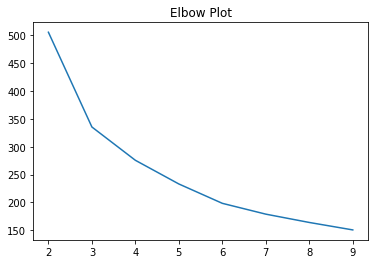

In [37]:
# creating a simple clustering model of vessels using KMeans

vessel_hours = df2.groupby(['vessel', 'quad'])['hour_delta'].sum().abs().reset_index()
vessel_df = vessel_hours.pivot(index='vessel', columns='quad', values='hour_delta').fillna(0)
vessel_df = vessel_df.div(vessel_df.sum(axis=1), axis=0)
vessel_df = vessel_df.merge(voyages_df.groupby('vessel')['voyage_dist'].mean(), left_index=True, right_index=True)

# scaling the values
scaler = StandardScaler()
scaled_vessel_df = scaler.fit_transform(vessel_df)

# using a loop to determine the number of clusters to use
kmeans_inertias = []

for n in range(2, 10):
  kmeans_vessels = KMeans(n_clusters=n)
  kmeans_vessels.fit(scaled_vessel_df)
  kmeans_inertias.append(kmeans_vessels.inertia_)


plt.plot(range(2,10), kmeans_inertias)
plt.title("Elbow Plot")
plt.show()


In [40]:
# the kmeans model that's used in the xgboost model - 3 works better than 6 
# when incorporated into the model

kmeans_vessels = KMeans(n_clusters = 3)
kmeans_vessels.fit(scaled_vessel_df)

kmeans_vessels.labels_

vessel_df['labels'] = kmeans_vessels.labels_

# creating a dictionary with the labels
kmeans_labels = {v:label for v, label in zip(vessel_df.index, vessel_df['labels'])}

In [41]:
def prepare_data(df, n_input = 3):
  """
  preparing the sequences for window based models
  """

  df = get_voyages(df)
  vessel = df['vessel'].iloc[0]
  ports_ = np.array(df['begin_port_id'].append(pd.Series(df['end_port_id'].iloc[-1])))  

  X = []
  Y = []
  start = 0

  for i in range(len(ports_)):
    last_input = start + n_input
    last_output = last_input + 3
    if last_output <= len(ports_):
      x = ports_[start:last_input]
      y = ports_[last_input: last_output]
      X.append(x)
      Y.append(y)
      start += 1
  try:
    df = pd.concat([pd.DataFrame(X),
                  pd.DataFrame(Y, columns=['port_1ahead', 'port_2ahead', 'port_3ahead'])], axis=1)
    
  except:
    df = pd.DataFrame()
    
  # X = []

  # for x in X:
  #   for n in x:
  #     if n == -75:
  #       port_coords = [33, 140]
  #     else:
  #       port_coords = list(ports[n])
  #     port = [n]
  #     port.extend(port_coords)
  #     new_X.append(port)
  
  df['vessel'] = len(df) * [vessel]
  df['kmeans_label'] = [kmeans_labels[n] for n in df['vessel']]
  
  return df.astype(int)

In [149]:
def build_model(target='port_1ahead', min_samples=1, n_back = 3):

  model_df = pd.concat([prepare_data(processed_dfs[key], n_back) for key in processed_dfs.keys()]) 

  model_df['cluster_1back'] = [db_labels[n] for n in model_df[0]]
  model_df['cluster_2back'] = [db_labels[n] for n in model_df[1]]
  model_df['cluster_3back'] = [db_labels[n] for n in model_df[2]]

  examples = model_df[target].value_counts()
  singles = examples[examples<3].index

  model_df = model_df[~model_df[target].isin(singles)]

  model_df['samples'] = model_df.groupby('vessel')['vessel'].transform(lambda x: x.count())
  filtered_df = model_df.query('samples > @min_samples')

  vessels_excluded = set(model_df['vessel'].unique()).difference(set(filtered_df['vessel'].unique()))

  features = [n for n in range(n_back)] + ['cluster_1back', 'cluster_2back', 'cluster_3back', 'kmeans_label'] 
  target = target

  X = filtered_df[features]
  y = filtered_df[target]
  model = XGBClassifier()

  param_grid = {
      'learning_rate': [0.01, 0.05, 0.1]
  }

  grid_search = GridSearchCV(model, param_grid, cv=3)
  grid_result = grid_search.fit(X, y)

  print('The training excluded vessels:', vessels_excluded)
  print('The best model params were:', grid_result.best_params_)
  print('The best accuracy achieved was:', grid_result.best_score_)
  
  return grid_result

In [150]:
model_1ahead = build_model(target='port_1ahead', min_samples=2, n_back=3)
model_2ahead = build_model(target='port_2ahead', min_samples=2, n_back=3)
model_3ahead = build_model(target='port_3ahead', min_samples=2, n_back=3)

The training excluded vessels: {107, 75, 85}
The best model params were: {'learning_rate': 0.05}
The best accuracy achieved was: 0.40509069898909283
The training excluded vessels: {107, 75, 85}
The best model params were: {'learning_rate': 0.01}
The best accuracy achieved was: 0.3873821302489781
The training excluded vessels: {107, 75, 85}
The best model params were: {'learning_rate': 0.05}
The best accuracy achieved was: 0.3498648136344511


In [145]:
def build_cat_model(target='port_1ahead', n_back=3, n_iterations=100):

  cat_df = pd.concat([prepare_data(processed_dfs[key], n_back) for key in processed_dfs.keys()])
  cat_df['cluster_1back'] = [db_labels[n] for n in cat_df[0]]
  cat_df['cluster_2back'] = [db_labels[n] for n in cat_df[1]]
  cat_df['cluster_3back'] = [db_labels[n] for n in cat_df[2]]
  cat_df['cluster_4back'] = [db_labels[n] for n in cat_df[3]]

  examples = cat_df[target].value_counts()
  singles = examples[examples<2].index

  cat_df = cat_df[~cat_df[target].isin(singles)]
  features = [0, 1, 2, 'kmeans_label', 'cluster_1back', 'cluster_2back', 'cluster_3back']

  cat_train = cat_df[features].astype(int)

  cat_train_targets = cat_df[target]

  X_train, X_test, y_train, y_test = train_test_split(cat_train, cat_train_targets, test_size=0.2, stratify=cat_train_targets)

  cat_features = [0, 1, 2, 3, 4, 5, 6]

  cat_train = Pool(X_train,
                  label=y_train,
                  cat_features=cat_features)

  cat_eval = Pool(X_test,
                  label=y_test,
                  cat_features=cat_features)


  cat = CatBoostClassifier(iterations=n_iterations,
                           loss_function='MultiClass')

  cat.fit(cat_train,
          eval_set=cat_eval,
          early_stopping_rounds=4)
  
  print('The feature importances of the model are:', cat.feature_importances_)
  print('The accuracy of the model on the test set is:', cat.eval_metrics(cat_eval, metrics='Accuracy'))
  
  return cat

In [ ]:
cat_model_1ahead = build_cat_model(target='port_1ahead')
cat_model_2ahead = build_cat_model(target='port_2ahead')
cat_model_3ahead = build_cat_model(target='port_3ahead') 

In [124]:
x = cat_model_3ahead.predict(cat_train)

In [43]:
def get_pred_data(df, n_input = 3):
  """
  preparing the sequences for predictions with the XGBClassifier model
  """

  df = get_voyages(df)
  vessel = df['vessel'].iloc[0]
  ports_ = np.array(df['begin_port_id'].append(pd.Series(df['end_port_id'].iloc[-1])))
  
  pred_seq = ports_[-n_input:]

  if len(pred_seq) < n_input:
    pred_seq = np.insert(pred_seq, 0, pred_seq[-1])
  
  return pred_seq

In [ ]:
# creating a dictionary with the most recent ports visited for each vessel

window_data = {key:get_pred_data(processed_dfs[key], n_input=3) for key in processed_dfs.keys()}

In [ ]:
# creating a dataframe with the features used in the models

sub = pd.DataFrame.from_dict(window_data, orient='index')

sub['cluster_1back'] = [db_labels[n] for n in sub[0]]
sub['cluster_2back'] = [db_labels[n] for n in sub[1]]
sub['cluster_3back'] = [db_labels[n] for n in sub[2]]
sub['kmeans_label'] = [kmeans_labels[n] for n in sub.index]

In [ ]:
# predicting the next port. also including the second most likely port in case
# the model predicts duplicates. 

port_1 = model_1ahead.predict(sub)
port_2 = model_2ahead.predict(sub)
port_2_alt = [model_2ahead.best_estimator_.classes_[np.argsort(n)[-2]] for n in model_2ahead.predict_proba(sub)]
port_3 = model_3ahead.predict(sub)
port_3_alt = [model_3ahead.best_estimator_.classes_[np.argsort(n)[-2]] for n in model_3ahead.predict_proba(sub)]
sub['port_1ahead'] = port_1
sub['port_2ahead'] = port_2
sub['port_2ahead_2nd'] = port_2_alt
sub['port_3ahead'] = port_3
sub['port_3ahead_2nd'] = port_3_alt

In [ ]:
# using conditional assignment to replace port predictions with the second most
# likely

sub.loc[sub['port_1ahead'] == sub['port_2ahead'], 'port_2ahead'] = sub['port_2ahead_2nd']
sub.loc[sub['port_2ahead'] == sub['port_3ahead'], 'port_3ahead'] = sub['port_3ahead_2nd']

In [ ]:
# changing the shape of the dataframe so it conforms to what's required

# resetting the index and renaming the column
sub = sub.reset_index()
sub.rename(columns={'index':'vessel'}, inplace=True)

# limiting columns to those required and renaming
sub = sub[['vessel', 2, 'port_1ahead', 'port_2ahead', 'port_3ahead']]
sub.rename(columns={2:'final_port'}, inplace=True)

# using melt to narrow the DataFrame and put the voyages into the same column
sub = pd.melt(sub, id_vars='vessel').sort_values(by=['vessel', 'variable'])
sub['end_port_id'] = sub.groupby('vessel')['value'].transform(lambda x: x.shift(-1))
sub = sub.dropna()

# adding a voyage count, more renaming
sub['voyage'] = sub.groupby('vessel').cumcount()+1
sub.rename(columns={'value' : 'begin_port_id'}, inplace=True)
sub.drop(columns=['variable'], inplace=True)
sub['end_port_id'] = sub['end_port_id'].astype(int)
sub = sub.reset_index(drop=True)

Creating an LSTM model to predict the future voyages. 

In [ ]:
# creating a dataset to train the LSTM model. i had to do a bit of troubleshooting,
# hence the try/except

lstm_data = []

for i in processed_dfs.keys():
  try:
    x = prepare_data(processed_dfs[i], n_input=6)
    lstm_data.append(x)
  except:
    print(i)

In [ ]:
# a dictionary to encode the ports for the model

encoder = {key:value for key, value in zip(df1['port'], df1.index)}

In [ ]:
# concatenating the LSTM data
lstm_df = pd.concat(lstm_data)

# defining the number of ports
total_ports = len(encoder.keys())

# slicing off the feature array
X = lstm_df[[0, 1, 2, 3, 4, 5]]

# encoding each port to create a "vocabulary" of ports starting at index 0
for col in X.columns:
  X.loc[:,col] = X[col].map(encoder)

# creating the target array with shape (samples, 3, 1) and converting to category
y = lstm_df[['port_1ahead', 'port_2ahead', 'port_3ahead']]
y = to_categorical(y)

# train and test split to validate model during training - could use 'validation_split' in .fit()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1944)

# initializing the Sequential class
model = Sequential()

# adding an embedding layer to embed each port in a 3 dimensional space
model.add(Embedding(total_ports, 3, input_length=6))

# adding an LSTM layer to process the embedded vector sequences
model.add(LSTM(100, activation='relu', return_sequences=False))

# adding a crucial layer to allows the output sequence to be of a diff length
model.add(RepeatVector(3))

# another LSTM layer, this one repeating the sequence
model.add(LSTM(50, activation='relu', return_sequences=True))

# model.add(Dense(50, activation='relu'))                                  <-------- layer i added/subtracted

# adding a TimeDistributed Dense layer to output predictions. note the # of 
# categories is not 'efficient' but it does make decoding the prediction take one
# fewer step

model.add(TimeDistributed(Dense(179, activation='softmax')))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# fitting the model with early stopping

history = model.fit(X_train,y_train,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    epochs=250,
                    callbacks=EarlyStopping(monitor='val_accuracy',
                                            patience=30,
                                            restore_best_weights=True));

In [ ]:
lstm_window = {key:get_pred_data(processed_dfs[key], n_input=6) for key in processed_dfs.keys()}

In [ ]:
# getting the sequences and encoding them so the model can use them as inputs
seq_for_pred = np.array([[encoder[j] for j in n] for n in lstm_window.values()])

# padding the sequences with fewer than 6 
seq_for_pred = pad_sequences(seq_for_pred, maxlen=6, value=0)

# predicting the next 3 ports visited
preds = model.predict(seq_for_pred)

In [ ]:
# assigning the predictions and back-up predictions to variables. if a port
# repeats, i replace it with the second most likely
first_port = pd.Series([np.argmax(n[0]) for n in preds])
second_port = pd.Series([np.argmax(n[1]) for n in preds])
alt_second = pd.Series([np.argsort(n[1])[-2] for n in preds])
third_port = pd.Series([np.argmax(n[2]) for n in preds])
alt_third = pd.Series([np.argsort(n[2])[-2] for n in preds])

In [ ]:
# creating a dataframe of the above
last_port = pd.Series(seq_for_pred[:,-1])
lstm_pred = pd.concat([last_port, first_port, second_port, alt_second, third_port, alt_third], axis=1)
lstm_pred.index = window_data.keys()
lstm_pred = lstm_pred.reset_index()
lstm_pred.columns = ['vessel', 'last_port', 'pred1', 'pred2', 'alt2', 'pred3', 'alt3']
lstm_pred['pred2'] = np.where(lstm_pred['pred1'] == lstm_pred['pred2'], lstm_pred['alt2'], lstm_pred['pred2'])
lstm_pred['pred3'] = np.where(lstm_pred['pred2'] == lstm_pred['pred3'], lstm_pred['alt3'], lstm_pred['pred3'])
lstm_pred.drop(columns=['alt2', 'alt3'], inplace=True)

In [ ]:
reverse_encoder = {v:k for k, v in encoder.items()}
lstm_pred['last_port'] = lstm_pred['last_port'].map(reverse_encoder)

In [ ]:
lstm_pred = pd.melt(lstm_pred, id_vars='vessel').sort_values(by=['vessel', 'variable'])

lstm_pred['end_port_id'] = lstm_pred.groupby('vessel')['value'].transform(lambda x: x.shift(-1))
lstm_pred.dropna(inplace=True)
lstm_pred.drop(columns='variable', inplace=True)
lstm_pred.rename(columns={'value':'begin_port_id'}, inplace=True)
lstm_pred['voyage'] = lstm_pred.groupby('vessel').cumcount()+1
lstm_pred = lstm_pred.astype(int).reset_index(drop=True)

In [ ]:
# i think i'm messing up, but the XGB model is fine - review this
lstm_pred.head(25)

In [ ]:
sub.to_csv('predict.csv', index=False)
# lstm_pred.to_csv('lstm_predict.csv', index=False)
voyages_df.to_csv('voyages.csv', index=False)

In [ ]:
def show_routes(vessel=1, start='2019-01-01', end='2019-12-28'): 
  
  df_ = df2.query(f'vessel == {vessel}').set_index('datetime')

  fig = px.scatter_geo(df_.loc[start: end], lat='lat', lon='long', color='draft',
                       hover_name=df_.loc[start: end].index)

  fig.show()

In [ ]:
def draft_and_voyages(vessel=103):

  df = alldf.query(f'vessel == {vessel}')
  
  in_port = df[df['pred_port'] > 0].index

  fig, ax = plt.subplots(figsize=(20,5))
  
  df[['port_dist', 'draft']].plot(ax=ax)
  
  for p in in_port:
    plt.axvline(p, ls='--', lw=0.5, c='r', label='port')
  
  plt.show()

In [ ]:
alldf = pd.concat(processed_dfs)

alldf.query('pred_port >0 & heading_sequence_time <7').shape

In [ ]:
testdf = processed_dfs[67]

In [ ]:
testdf[['draft', 'pred_port']].plot(figsize=(24,8))

In [ ]:
print(testdf[['draft', 'pred_port', 'pred_port_backup', 'pred_port_dist', 'port_sequence_time', 'consec_port_sequence', 'hour_delta', 'direction', 'heading_seq', 'lat_long', 'dist_last_port']].to_string())

In [ ]:
fig = px.scatter_geo(df2.query('vessel == 152'), lat='lat', lon='long', color='direction', hover_name='pred_port')

fig.show()

In [154]:


voyages_df.query('vessel == 1')[['begin_date', 'end_date']]

,begin_date,end_date
0,2019-01-01,2019-01-16
1,2019-01-17,2019-02-03
2,2019-02-14,2019-03-01
3,2019-03-02,2019-03-16
4,2019-03-17,2019-04-11
5,2019-04-12,2019-05-14
6,2019-07-17,2019-08-12
7,2019-08-14,2019-09-14
8,2019-09-16,2019-09-30
9,2019-10-01,2019-10-16


In [153]:
v1 = processed_dfs[1]

print(v1[['pred_port', 'draft', 'speed', 'heading_sequence_time']].to_string())

                     pred_port   draft  speed  heading_sequence_time
datetime                                                            
2019-01-01 02:47:00        138   9.600    0.0              16.650000
2019-01-01 05:47:00        138   9.600    0.0              16.650000
2019-01-01 06:59:00        138   9.600    0.0              16.650000
2019-01-01 08:53:00        138   9.600    0.0              16.650000
2019-01-01 10:53:00        138   9.600    0.0              16.650000
2019-01-01 11:56:00        138   9.600    0.0              16.650000
2019-01-01 13:47:00        138   9.600    0.0              16.650000
2019-01-01 14:59:00        138  11.500    0.0              16.650000
2019-01-01 16:56:00        138  11.500    0.0              16.650000
2019-01-01 17:54:00        138  11.500    0.0              16.650000
2019-01-01 19:26:00          0  11.500   10.6               1.366667
2019-01-01 20:48:00          0  11.500    8.3               1.916667
2019-01-01 22:43:00          0  11